# Differentiation of Benign and Malignant Breast Lesions Using Random Forests

By: David Lee

November 19, 2017

## Contents

- [Introduction](#intro)
    - [Project Overview](#project_overview)
    - [Background and Motivation](#BnM)
    - [Process Overview](#process_overview)

- [Import Libraries and Configure Matplotlib](#import)
- [Data](#data)
    - [Splitting Data](#split)
    - [Standardization](#standardization)

- [Exploratory Data Analysis](#eda)
    - [Feature Analysis](#feature)

- [Prototyping](#prototyping)
    - [Training](#trainingp)
    - [Testing](#testingp)

- [Model Development](#model_dev)
    - [Training](#trainingm)
    - [Testing](#testingm)
    - [Threshold Selection](#threshold)
    - [Final Development](#final)

- [Conclusions](#conclusions)
    - [Next Steps](#next_steps)

<a id='intro'></a>
## Introduction


<a id='project_overview'></a>
### Project Overview

My goal is to use machine learning to develop a classifier that generates a highly accurate diagnosis of whether the cells from a breast mass are  malignant (cancerous) or benign (noncancerous). The classifier performs the diagnosis on a basis of cytological features extracted from digitized images of fine needle aspiration biopsies. The classifier may be a potential solution to certain challenges inherent in this popular biopsy procedure, resulting in greater diagnostic accuracy and continued reduction in breast cancer mortality.

<a id='BnM'></a>
### Background and Motivation

Breast cancer is a leading cause of death among women and is the most commonly diagnosed cancer globally. However, the outlooks for those affected by this disease have improved significantly over the past several decades. In particular, improved screening programs and public awareness of breast cancer have been vital to reducing the mortality rates from this disease.

In many circumstances, the conditions in which cancers are detected and diagnosed in a patient are key determinants for the likelihoods of successful treatment. Generally, cancers are most treatable when detected in their early developmental stages. In fact, survival rates for early-stage breast cancer are typically upwards of 90%. Comparatively, the survival rates for later stage cancers are significantly lower. This particular property is the reason that the dissemination of regular screening and self-check practices have been so effective at reducing mortality.

Certainly, considerable progress has been made due in large part to the improved efforts toward detection and diagnosis. However, certain challenges remain. Fine needle aspiration cytology (FNAC) is an established and widely practiced procedure for the diagnosis of abnormalities, or lesions, in breast tissue. Like other forms of biopsy procedures, FNAC involves the extraction of tissue samples for close examination. In the context of breast cancer, FNAC is used to determine whether tissue abnormalities are malignant or benign. Moreover, the procedure widely accessible because it is rapid, sensitive, safe, and inexpensive.

However, despite its numerous advantages, the technique has inherent limitations. Though FNAC is able to correctly diagnose a tissue sample the majority of the time (typically upwards of 90% sensitivity), the consequences of misclassification errors are severe enough to necessitate the consideration of improved strategies which might lead to greater accuracy. False negative errors, the misclassification of malignant lesions as benign, may cause cancerous growths to go unnoticed, resulting in an increased likelihood of mortality. On the other hand, false positive errors, the misclassification of benign lesions as malignant, may cause unwarranted emotional distress in patients and elicit additional costs in the forms of superfluous testing, treatment, or even lawsuits.

The risk of misdiagnosis by FNAC is inherent in the methodology. In FNAC, a very thin needle is used to extract a small sample of cells from the area of interest. Due to the small sample size, there is a considerable risk that the extracted cells do not adequately represent the tissue as a whole. Furthermore, the small sample size necessitates an analysis based primarily on the characteristics of individual cells, rather than on groups of cells. This is problematic because malignant cells can typically be discerned from healthy cells by their organizational structure around neighboring cells. Because this information is typically not captured by FNAC, the technique is particularly susceptible to misclassification of samples which, based exclusively on cellular features, are neither distinctly benign or clearly malignant. These are known as "gray zone lesions", and they are exceptionally difficult to interpret by standard methods, even by experienced pathologists.

The introduction of classifier systems in medical diagnosis may resolve some of these challenges. Certainly, the decisions of trained pathologists coupled with their evaluation of patient data are the most important factors in diagnosis. However, the development and application of artificial intelligence and machine learning systems can assist experts a great deal in diagnosis and decision-making. Machine learning systems developed on large databases of historical data can leverage that information to support physicians in conducting accurate diagnoses and reduce the classification challenges inherent in the classical FNAC methodology caused by inexperience and difficulties in interpretation.

<a id='process_overview'></a>
### Process Overview

There exists a large number of cellular features which can potentially be used to differentiate between malignant and benign cells. However, starting out, it is advantageous to prioritize training a simple model on a small subset of the most important features. In doing so, we may develop a more intuitive understanding of the data, establish a baseline estimate of the classifier's performance, and assess potential avenues for performance improvement. Then, given this information we will develop the final model on a larger set of features.

<a id='import'></a>
### Import Libraries and Configure Matplotlib

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc

from matplotlib import rcParams
from palettable.colorbrewer.qualitative import Set1_3
from palettable.colorbrewer.sequential import Greys_8


# Set some matplotlib defaults
rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 90
rcParams['axes.color_cycle'] = Set1_3.mpl_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = Set1_3.mpl_colors[0]
rcParams['axes.grid'] = False


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unneccesary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)

pd.set_option('display.max_columns', 30)

/home/david-ubuntu/anaconda3/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<a id='data'></a>
## Data

The data was sourced from the Wisconsin Breast Cancer Database, a collection of data obtained from the University of Wisconsin, Madison Hospital and Dr. William H. Wolberg. The data contains features computed from digitized images of fine needle aspirates of breast masses obtained from 569 patients. The features describe characteristics of the cell nuclei present in the image. Ten real-valued features were computed for each cell nucleus:
- radius: mean distance from the center to points on the perimeter
- texture: standard deviation of gray scale values
- perimeter
- area
- smoothness: local variation in radius lengths
- compactness: perimeter^2/area - 1.0
- concavity: severity of concave portions of the contour
- concave points: number of concave points on the contour
- symmetry
- fractal dimension: "coastline approximation" - 1

The mean, standard error, and "worst" (mean of the three largest values) of each feature were computed for each image, resulting in 30 features.

Finally, each instance has one of two possible diagnoses:
- benign (non-cancerous)
- malignant (cancerous)

In [2]:
attributes = ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']

data = pd.read_csv('data/wdbc.data', header=None, names = attributes)

In [3]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,...,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,...,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,...,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,...,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,...,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,...,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


We will begin with some minor data manipulation and preprocessing. Because most machine learning algorithms require quantitative data, it would be beneficial to map the diagnosis labels to discrete numeric values for the classification problem. 0 is used to denote benign and 1 is used to denote malignant.

In [4]:
# y is the vector of the target variable. 
# X is the array of computed features.

y = data.diagnosis.map({'M':1, 'B':0})
X = data.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1)

In [5]:
# display descriptive statistics of feature values for a summary of the data.
X.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


<a id='split'></a>
### Splitting Data

I prepared two different test sets because I expect to perform an additional model selection step after training the classifier.

Simply put, due to the unequal weights in misclassification cost between false negative and false positive results, it may be necessary to adjust the discrimination threshold the classifier uses to make predictions. Many classifiers predict classes based on the probability that a certain observation is a certain class over others. If the probability that the observation belongs to a particular class is above a certain threshold, then the classifier assigns the observation to that class. By default, the discrimination threshold is 0.5, meaning that if the probability that an observation belongs to a particular class is computed to be greater than 50%, then the classifier will assign the observation to that class. 

For example, in our context a classifier might predict the probability that a particular observation is malignant to be 0.60. Because this probability is greater than the default threshold probability of 0.5, the observation will be labeled by the classifier as malignant. On the other hand, the classifier might predict the probabilty that a different observation is malignant to be 0.47. Thus, it follows that the classifier will label the observation as benign. This may be problematic in this situation because the cost of false negatives (incorrectly labeling malignant tumors as benign) is much greater than the 
cost of false positives. As a result, a more conservative threshold may be desired for the prediction. For example, if we choose a discrimination threshold of 0.30, then the classifier will label any observation is malignant if the classifier computes at least a 30% chance of malignancy. Thus, the classifier will successfully detect malignancy in more patients who are truly sick. .

The tradeoff is that the classifier may now produce more false positives (incorrectly labeling benign tumors as malignant). Clearly, we desire the minimization of both types of misclassification errors, but due to the severity of the consequences associated with false negative outcomes, we should prioritize the minimization of that error type to a greater degree. As a result, as a part of development, the discrimintation threshold for the classifier must be selected as well. An additional test set is reserved for this purpose.

In [6]:
# the final test set to be used to assess model performance after choosing probability threshold for the classifier.
X_ss, X_test_final, y_ss, y_test_final = train_test_split(X, y, test_size=0.2, stratify=y)

In [7]:
# the test set to be used to assess model performance after training the classifier.
X_train, X_test, y_train, y_test = train_test_split(X_ss, y_ss, test_size=0.2, stratify=y_ss)

<a id='standardization'></a>
### Standardization

Before moving on to data analysis, I normalize the values of each feature such that each feature vector takes a mean value of 0 and standard deviation of 1. This transformation is performed for visualization purposes only. The descriptive statistics computed in the previous section reveal the wide range of values taken by the various features. Thus, to ensure the values can fit on the same scale, normalization is necessary.

In [8]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [9]:
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)

<a id='eda'></a>
## Exploratory Data Analysis

I begin my analysis by examining the proportion of each class in the sample.

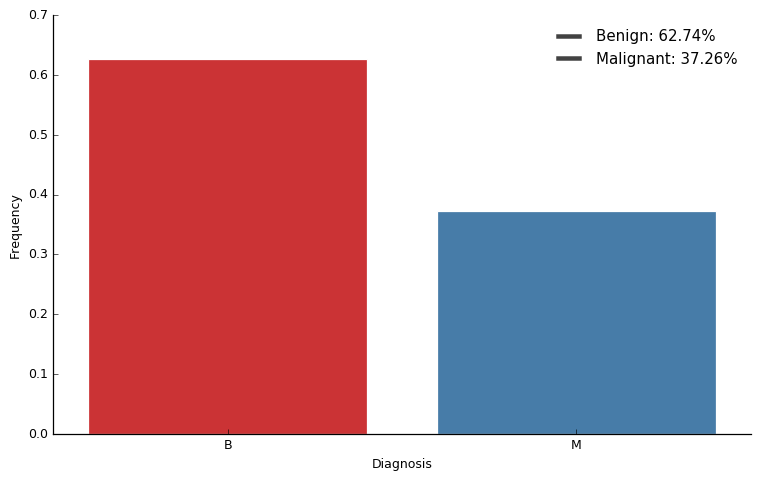

In [10]:
B, M = y.value_counts(normalize=True)
ax = sns.barplot(x=['B', 'M'], y = [B, M])
ax.set_xlabel('Diagnosis')
ax.set_ylabel('Frequency')
ax.legend(['Benign: %0.2f' %(B*100) + '%', 'Malignant: %0.2f' %(M*100) + '%'], frameon=False, loc='upper right')
remove_border()

The class imbalance in the sample is consistent with the characteristics in the patient population. Medical records indicate that the majority of breast masses are benign. 

Furthermore, the imbalance reveals a minimum acceptable accuracy score as well. Imagine, for instance, we designed a classifier that diagnoses all samples as benign. While not a good classifier, it will have an accuracy score of 62.74%. Thus, we know that if a classifier we trained receives an accuracy score below this minimum value, then the classifier is clearly not doing its job. 

The class imbalance also indicates that accuracy may not be a very good indicator of classifier performance. Inherently, the accuracy metric provides no information on the types of misclassification errors the classifier is making. Thus, alternative metrics, such as the true positive rate, also known as sensitivity or recall, may be more informative. 

<a id='feature'></a>
### Feature Analysis

Exploring the features, I am interested in examining the distribution of values taken by each class for each feature. Features which tend to take on very different values depending on class label are particularly useful in differentiating between the classes.  

I explore the features using violin plots and swarm plots.

Violin plots show the distributions of quantitative data across categorical variables side by side so that they can be compared. Violin plots compute the distributions via kernel density estimation on the data. In this context, the categorical variables are our class labels: malignant and benign. 

Swarm plots are similar to violin plots. However, rather than displaying estimated distributions, swarm plots display the actual values observed in each feature as points adjusted in space so that the points do not overlap.

The plots complement each other well. Violin plots scale well to large amounts of data, but are disadvantaged due to the fact that the distributions only represent estimations of the underlying data. Swarm plots display the actual quantitative values of the data, but are disadvantaged in that the plots are unable to scale to display large amounts of data. Together they provide insights on the underlying distributions in the data. 

In [11]:
def plot_v_s(x, y, plot_type='violin'):
    plt.figure()
    df = pd.concat([y, x], axis=1)
    df = pd.melt(df, id_vars='diagnosis', var_name='features', value_name='value')
    if plot_type == 'swarm':
        sns.swarmplot(x='features', y='value', hue='diagnosis', data=df)
    elif plot_type == 'violin':
        sns.violinplot(x='features', y='value', hue='diagnosis', data=df, split=True, inner='quartile')
    plt.xticks(rotation=45)
    plt.legend(frameon=False, loc='upper left')

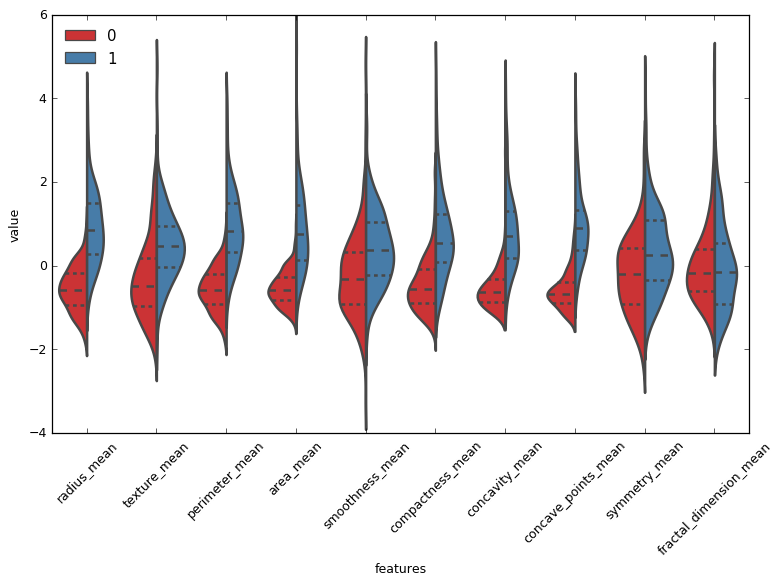

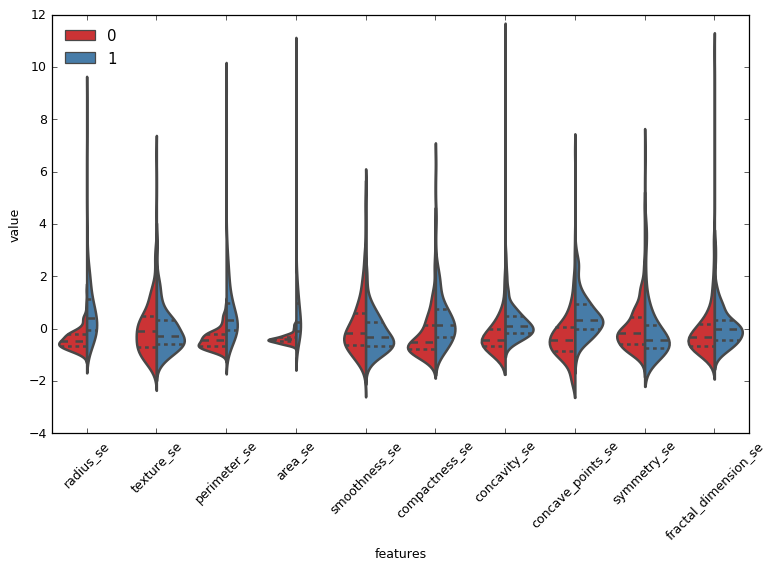

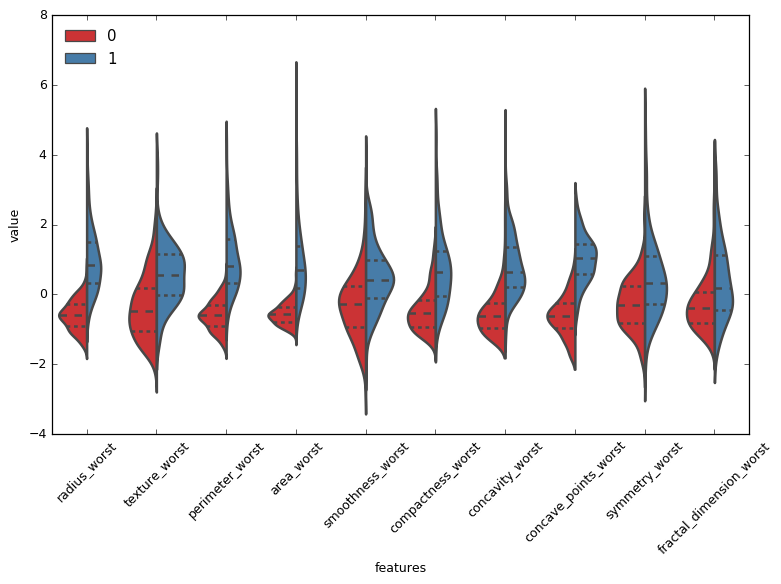

In [12]:
plot_v_s(X_train_scaled.iloc[:,0:10], y)
plot_v_s(X_train_scaled.iloc[:,10:20], y)
plot_v_s(X_train_scaled.iloc[:,20:30], y)


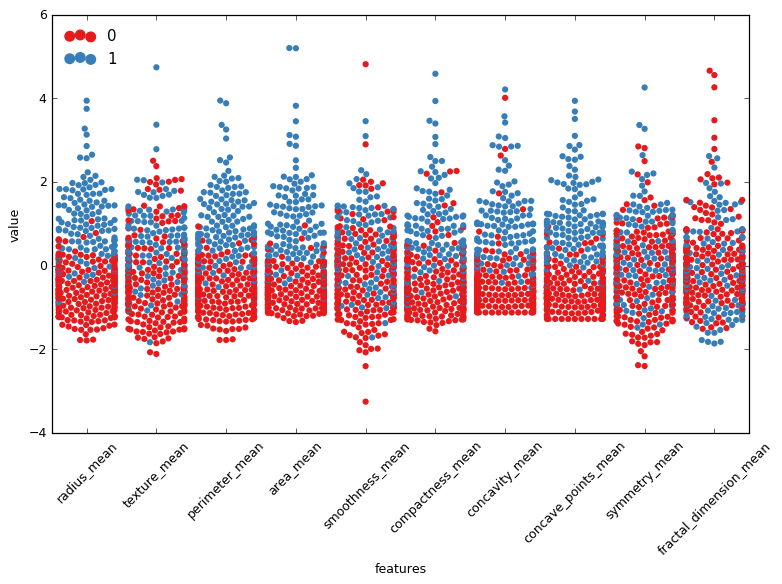

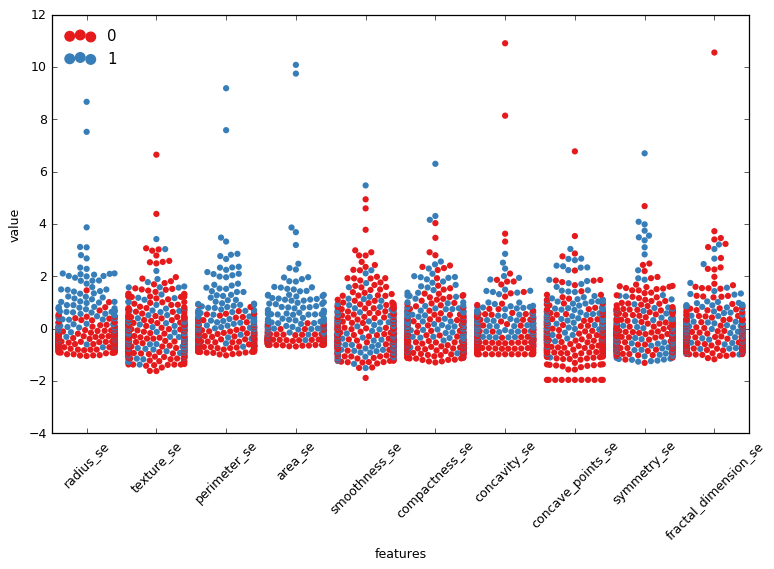

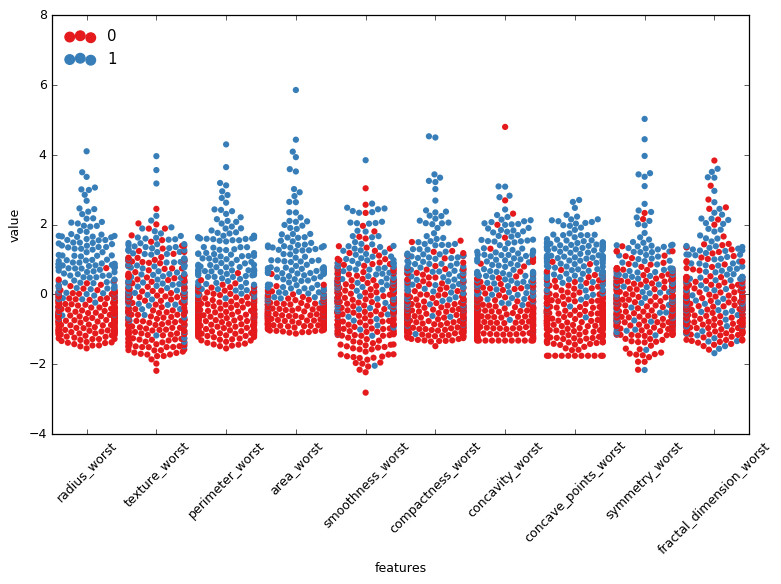

In [13]:
plot_v_s(X_train_scaled.iloc[:,0:10], y, 'swarm')
plot_v_s(X_train_scaled.iloc[:,10:20], y, 'swarm')
plot_v_s(X_train_scaled.iloc[:,20:30], y, 'swarm')


By inspection, we see that the features with the most potential for differentiating between the two classes are related to the radius and concavity of the cell nuclei.

Furthermore, based on the description of the features, it is clear that some correlation exists between features. For example, radius is correlated with perimeter and area. It is worth noting that by performing features selection, we can potentially reduce the computational complexity required to process the data during training. However, the computational expense during training is insignificant for such a small data set. Furthermore, so long as the features are not truly redundant (e.g. computed from each other), the features may still contribute to classification. 

<a id='prototyping'></a>
## Prototyping

In the previous section, we found, visually,  that the data may be linearly separable on two features. The two features which appear to best separate the classes are radius_worst and concave_points_worst. We can verify this by plotting a two-dimensional scatter plot on the features.

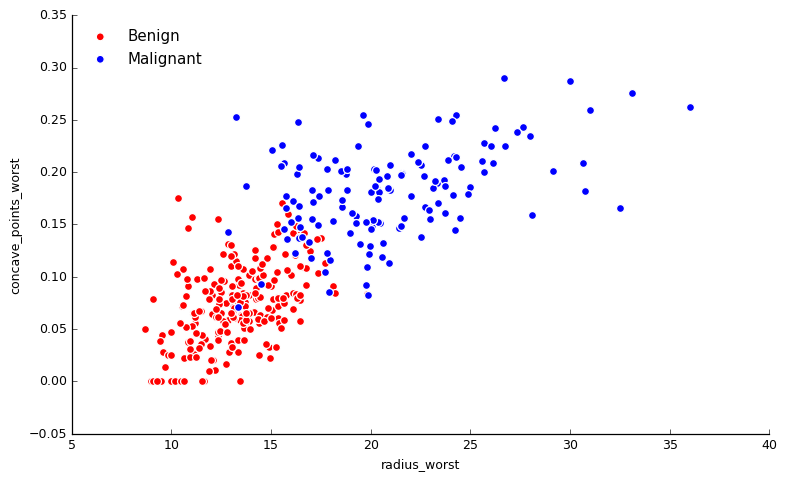

In [14]:
features = ['radius_worst', 'concave_points_worst']
colors=['red','blue']
ax=plt.gca()
for label in [0, 1]:
    color = colors[label]
    mask = y_train == label
    l = 'Benign' if label == 0 else 'Malignant'
    ax.scatter(X_train[mask][features[0]], X_train[mask][features[1]], c=color, s=40, label=l)

plt.legend(frameon=False, scatterpoints=1, loc='upper left')
plt.xlabel(features[0])
plt.ylabel(features[1])
remove_border()


The plot of the data indicates that with a only few misclassification errors, the data is linearly separable on the basis of these two features. As a result, we can train a simple classifier which generates a diagnosis based on data only from these two features. 

There are several reasons for beginning with a simple model over a more complex one. The simple model may act as a prototype for future models by providing a baseline measure of classifier performance, as well as provide insight into high-potential avenues for performance improvement. The prototype will also help in developing an intuition for the underlying data via reduction in complexity associated with high dimensionality. In fact, perhaps the most obvious benefit of dimensionality reduction is the potential for visualization, which not possible in high-dimensional problems.

<a id='trainingp'></a>
### Training

I use regularized logistic regression to develop the simple model. Logistic regression is a simple, effective, and efficient classification algorithm which is well-suited for the problem due to the small feature space of the data. The logistic regression is regularized to balance bias-variance tradeoff, yielding a classifier which generalizes well to future data. The regularization parameter in logistic regression is tuned via 10-fold cross-validation. 

In [15]:
pipeline_lr = make_pipeline(preprocessing.StandardScaler(), LogisticRegression())

In [16]:
hyperparameters_lr = {"logisticregression__C": [1e-7,0.1e-6, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000]}
clf_lr = GridSearchCV(pipeline_lr, param_grid=hyperparameters_lr, cv=10)
clf_lr.fit(X_train[['radius_worst', 'concave_points_worst']], y_train)
clf_lr.best_estimator_, clf_lr.best_params_, clf_lr.best_score_, clf_lr.grid_scores_

/home/david-ubuntu/anaconda3/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


(Pipeline(memory=None,
      steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False))]),
 {'logisticregression__C': 0.001},
 0.94230769230769229,
 [mean: 0.93956, std: 0.04224, params: {'logisticregression__C': 1e-07},
  mean: 0.93956, std: 0.04224, params: {'logisticregression__C': 1e-07},
  mean: 0.93956, std: 0.04224, params: {'logisticregression__C': 1e-06},
  mean: 0.93956, std: 0.04224, params: {'logisticregression__C': 1e-05},
  mean: 0.93956, std: 0.04224, params: {'logisticregression__C': 0.0001},
  mean: 0.94231, std: 0.03803, params: {'logisticregression__C': 0.001},
  mean: 0.93956, std: 0.03863, params: {'logisticregression__C': 0.01},
  mean: 0.93956, std:

The decision boundary generated by the classifier is visualized below along with the training and test data. The decision boundary reflects a discrimination threshold of 0.5. When given new unlabeled data, the classifier will predict data located in the blue region to be malignant and data located in the red region to be benign.

In [17]:
# Adapted from notebook for CS109 by Harvard's Rahul Dave
from matplotlib.colors import ListedColormap
def points_plot(X_train, X_test, y_train, y_test, clf):

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    X=np.concatenate((X_train, X_test))
    
    # evenly sampled points
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    #plot background colors
    ax = plt.gca()
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.3, axes=ax)

    
    # Plot the training points
    ax.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 'ro', label='Benign')
    ax.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 'bo', label='Malignant')
        
    # and the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c='k', marker="s", s=70, facecolors="k", alpha=.5, label='Test data')
    plt.legend(loc='upper left', scatterpoints=1, numpoints=1)

    return ax


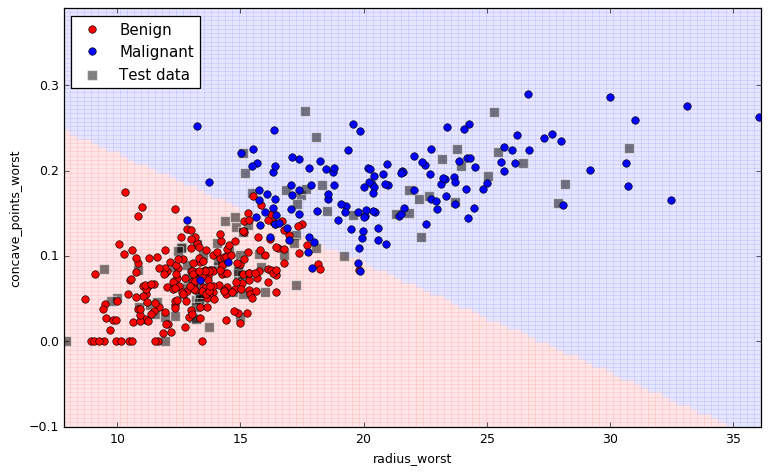

In [18]:
plt.figure()
ax=plt.gca()
points_plot(X_train[features].values, X_test[features].values, y_train.values, y_test.values, clf_lr);
plt.xlabel(features[0])
plt.ylabel(features[1])


<a id='testingp'></a>
### Testing

A confusion matrix is a table that describes the performance of a classification model on a set of test data for which the true values are known. In a classification problem, a confusion matrix is more informative than an accuracy score because it displays the error rates for each type of misclassification type. To recap:

- samples that are positive, which the classifier correctly predicts as positive are called True Positives (TP)
- samples that are negative, which the classifier incorrectly predicts as positive are called False Positives (FP)
- samples that are negative, which the classifier correctly predicts as negative are called True Negatives (TN)
- samples that are positive, which the classifier incorrectly predicts as negative are called False Negatives (FN)

<img src="files/images/confusionmatrix.png">
<center>Source: Harvard University, School of Engineering and Applied Sciences</center>

In addition to these definitions, we define several other useful metrics. The first is the true positive rate (TPR).

 $$TPR = Recall = Sensitivity = \frac{TP}{OP} = \frac{TP}{TP+FN}$$

The true positive rate is also commonly known as recall, or sensitivity. Recall describes the fraction of observed positives that the model correctly classifies. As a result, maximizing recall toward 1 is equivalent to minimizing the false negative rate. In our classifier, recall is the  metric we want to maximize. 

The next metric, the false positive rate (FPR), is defined as

$$FPR = \frac{FP}{ON} = \frac{FP}{FP + TN}$$

The false positive rate describes the fraction of observed negatives that the model incorrectly classifies. FPR is related to the selectivity of the model. Selectivity is defined as

$$Selectivity = 1- FPR = \frac{TN}{ON} = \frac{TN}{FP + TN}$$

As a result, maximizing selectivity toward 1 is equivalent to minimizing the false positive rate. Typically, we desire to maximize both sensitivity and selectivity. This is the case in our cancer classifier as well. However, due to the heavier cost of false negatives, sensitivity is the higher priority. Thus, we may choose to design a classifier that prioritizes very high sensitivity, even at the expense of slightly lower selectivity.

In machine learning, another metric more commonly used to reflect the false positive rate is precision. Precision is defined as

$$Precision = \frac{TP}{PP} = \frac{TP}{FP + TP}$$

Precision reflects the number of predicted positives which were actually positive. As a result, maximizing precision toward 1 is also equivalent to minimizing the false positive rate. In this project, I will instead represent the precision of the model as a component of another metric: the F1 score, which reflects the balance between precision and recall. The F1 score is defined as

$$F1 = \frac{2\cdot Recall \cdot Precision}{Recall + Precision}$$

All of these metrics can be computed directly from the confusion matrix, which we will compute below.

In [19]:
def plot_confusion_matrix_hm(clf, Xtest, ytest):
    cmatrix = metrics.confusion_matrix(ytest,clf.predict(Xtest))
    ax = sns.heatmap(cmatrix, cmap=Greys_8.mpl_colormap, square=True, annot=True, yticklabels=['observed B', 'observed M'], xticklabels=['predicted B', 'predicted M'])

Accuracy score: 0.945054945055
Recall score: 0.882352941176
F1 score: 0.923076923077


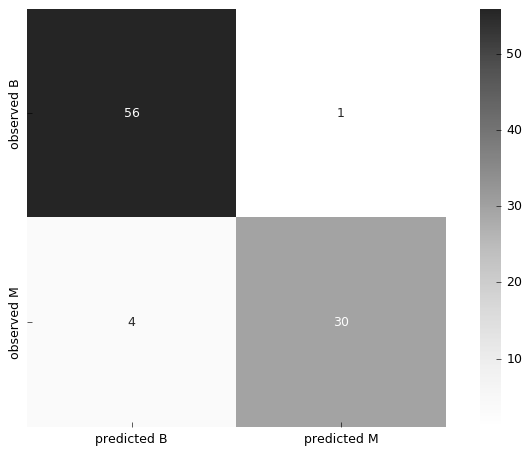

In [20]:
plot_confusion_matrix_hm(clf_lr, X_test[features], y_test)
print "Accuracy score:", metrics.accuracy_score(y_test, clf_lr.predict(X_test[['radius_worst', 'concave_points_worst']]))
print "Recall score:", metrics.recall_score(y_test, clf_lr.predict(X_test[['radius_worst', 'concave_points_worst']]))
print "F1 score:", metrics.f1_score(y_test, clf_lr.predict(X_test[['radius_worst', 'concave_points_worst']]))


Even when using only two features for classification, we find very high levels of accuracy and recall. These scores may act as a baseline for future models, which we can improve by training on a larger set of features and by modifying the discrimination threshold. We will develop the new model now. 

<a id='model_dev'></a>
## Model Development

This time, we will train a classifier using a random forest algorithm. Random forest is a powerful ensemble method that predicts using a collection of decision trees. The random forest is an appropriate choice for the problem because the algorithm is robust to underlying correlations in the data, which we detected during analysis. Furthermore, ensemble methods, like random forest, typically train models which generalize exceptionally well to future data. The random forest hyperparameters will be tuned via 10-fold cross validation.

<a id='trainingm'></a>
### Training

In [21]:
pipeline_rf = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=100))

In [22]:
hyperparameters_rf = {'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2', 0.2, 0.3], 'randomforestclassifier__max_depth': [None, 5, 3, 1]}
clf_rf = GridSearchCV(pipeline_rf, param_grid=hyperparameters_rf, cv=10)
clf_rf.fit(X_train, y_train)
clf_rf.best_estimator_, clf_rf.best_params_, clf_rf.best_score_, clf_rf.grid_scores_


/home/david-ubuntu/anaconda3/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


(Pipeline(memory=None,
      steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min...n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False))]),
 {'randomforestclassifier__max_depth': None,
  'randomforestclassifier__max_features': 'sqrt'},
 0.94230769230769229,
 [mean: 0.93407, std: 0.04551, params: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'auto'},
  mean: 0.94231, std: 0.04735, params: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt'},
  mean: 0.93407, std: 0.03892, params: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'log2'},
  mean: 0.93132, std: 0.05023, params: {'random

<a id='testingm'></a>
### Testing

Accuracy score: 0.978021978022
Recall score: 0.941176470588
F1 score: 0.969696969697


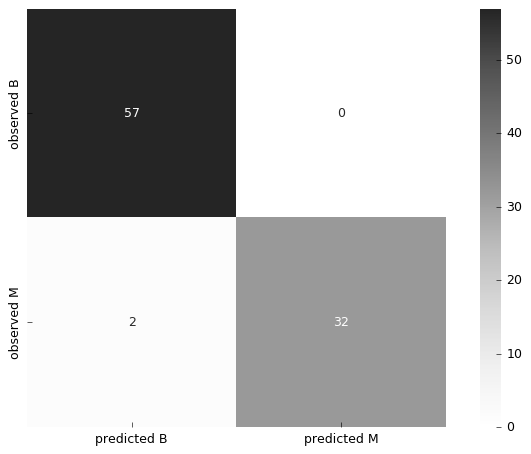

In [23]:
plot_confusion_matrix_hm(clf_rf, X_test, y_test)
print "Accuracy score:", metrics.accuracy_score(y_test, clf_rf.predict(X_test))
print "Recall score:", metrics.recall_score(y_test, clf_rf.predict(X_test))
print "F1 score:", metrics.f1_score(y_test, clf_rf.predict(X_test))

The trained model yields very high accuracy and recall. The recall and accuracy of this classifier are higher than the baseline, indicating that we may continue developing on this model. The confusion matrix reveals that the false negative issue is still present, however. As mentioned previously, it may be possible to remedy this by changing the discrimination threshold of the classifier. In doing so, we may minimize the risk of false negatives at the expense of false positives. After all, it is more acceptable to send healthy patients for cancer followups than it is to misdiagnose sick patients and leave them without treatment.

<a id='Threshold'></a>
### Threshold Selection
One way to select the threshold is by constructing a receiver operating characteristic curve, or ROC curve. An ROC curve illustrates the diagnostic ability of a binary classfier system as its discrimination threshold is varied. In other words, an ROC curve represents a set of classifiers at various threshold settings. The ROC curve is created by plotting the classifier's TPR against its FPR at discrimination thresholds ranging from 0 to 1.

In [24]:
# From notebook for CS109 by Harvard's Rahul Dave
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.7, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.7, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in xrange(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

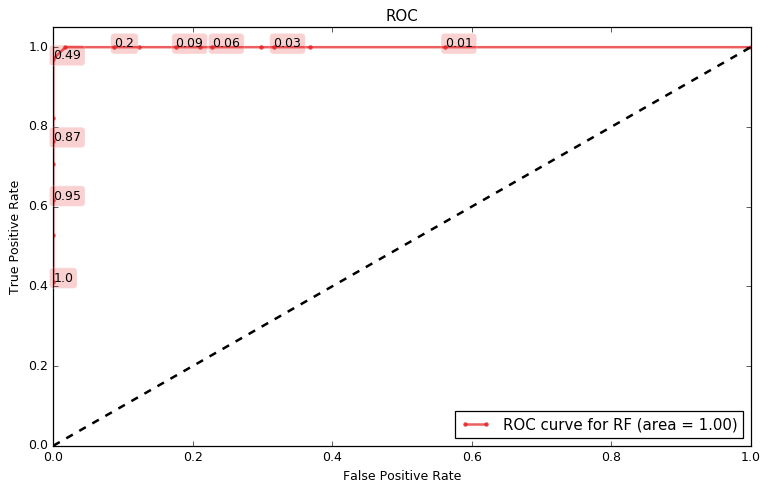

In [25]:
make_roc("RF",clf_rf, y_test, X_test, None, labe=2)

The optimal threshold may formally be selected using decision theory. The decision is made via the assignment of cost or utility functions to each of the classification outcomes and the computation of the expected utility or cost associated with each classifier. However, due to the nature of the problem, it is difficult to objectively assign costs to the outcomes without the input of a decision maker (a physician, pathologist, etc). For now, we may select the threshold visually; however, the option to incorporate decision theory into the selection process is always open. 

The key idea is that the primary objective is to maximize the true positive rate (i.e. minimize false negatives), while the secondary objective is to minimize the false positive rate (i.e. minimize false positives). To achieve these objectives, I choose a threshold of 0.40.

<a id='final'></a>
### Final Development

Because the training method has already been selected in the previous sections, I may now retrain on all of the data, and I will test the classifier on the final test set which I had reserved at the beginning.

In [26]:
clf_rf2 = RandomForestClassifier(n_estimators=100, max_features=clf_rf.best_params_['randomforestclassifier__max_features'], max_depth=clf_rf.best_params_['randomforestclassifier__max_depth'])
clf_rf2.fit(X_ss, y_ss)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
def repredict(clf, X, threshold):
    return (clf.predict_proba(X)[:,1] > threshold).astype(int)

Accuracy score: 0.982456140351
Recall score: 0.97619047619
F1 score: 0.97619047619


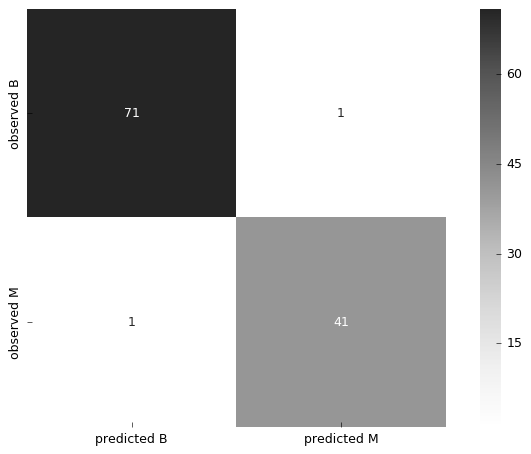

In [28]:
ax = sns.heatmap(metrics.confusion_matrix(y_test_final, repredict(clf_rf2, X_test_final, 0.40)), cmap=Greys_8.mpl_colormap, square=True, annot=True, yticklabels=['observed B', 'observed M'], xticklabels=['predicted B', 'predicted M'])
print "Accuracy score:", metrics.accuracy_score(y_test_final, repredict(clf_rf2, X_test_final, 0.40))
print "Recall score:", metrics.recall_score(y_test_final, repredict(clf_rf2, X_test_final, 0.40))
print "F1 score:", metrics.f1_score(y_test_final, repredict(clf_rf2, X_test_final, 0.40))

The model performance is very good. The recall of this final model is greater than the previous one. Additionally, the accuracy is high as well. A small trade-off in selectivity is the price paid for the very high sensitivity specification desired by the application.

<a id='conclusions'></a>
## Conclusions

The goal of the project was to resolve the challenges associated with breast cancer diagnosis via fine needle aspiration cytology by developing machine learning systems that produce highly accurate diagnoses. A prototype of the model was developed in order to establish a baseline for performance comparison and to provide information for future development. The key improvements on the prototype which were implemented in the final product included:
- the addition of 28 other cytological characteristics to the feature space of the model
- the training of the model via an ensemble method, the random forest algorithm
- the selection of an alternative discrimination threshold, reflecting the conservative nature of the medical application

The prototype performed well, in spite of its simplicity. However, the final model performed significantly better. When evaluated on the test data, the model achieved a recall of 97.6%, while maintaining an overall diagnostic accuracy of 98.2%. The accuracy achieved by the model is far greater than that achieved through existing approaches. In fact, the results suggest great promise for the model's application in medical diagnostics. The inclusion of machine learning to the diagnostic process provides pathologists and physicians the capacity to make powerful data-driven decisions for their patients. In fact, the continued development of machine learning systems for medicine may be the next step toward lower mortality rates from not only breast cancer but also other deadly diseases.

<a id='next_steps'></a>
### Next Steps

Significant improvements can be made to the model should more data be available. The model was trained on 569 instances, which is fairly sparse. In fact, I observed a moderate amount of variance when developing the model on different randomized sets of training data, which is a sign of overfitting. A larger training set will better reflect the true characteristics of the population, resulting in a reduction of model variance caused by the sparsity in data and a greater capacity to generalize to future data.